
# Balila, Edwin Klein 2019-22685


## STL-10 using Principal Component Analysis and Gaussian Mixture Model

##### Download STL-10 dataset from https://ai.stanford.edu/~acoates/stl10/

In [1]:
# load libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import math
from scipy import linalg as la

## Dataset Visualization

In [2]:
# code from https://github.com/mttk/STL10
# Function to read the files, referenced from stl10_input.py
def read_all_images(path_to_data):
    """
    :param path_to_data: the file containing the binary images from the STL-10 dataset
    :return: an array containing all the images
    """

    with open(path_to_data, 'rb') as f:
        # read whole file in uint8 chunks
        everything = np.fromfile(f, dtype=np.uint8)

        # We force the data into 3x96x96 chunks, since the
        # images are stored in "column-major order", meaning
        # that "the first 96*96 values are the red channel,
        # the next 96*96 are green, and the last are blue."
        # The -1 is since the size of the pictures depends
        # on the input file, and this way numpy determines
        # the size on its own.

        images = np.reshape(everything, (-1, 3, 96, 96))

        # Now transpose the images into a standard image format
        # readable by, for example, matplotlib.imshow
        # You might want to comment this line or reverse the shuffle
        # if you will use a learning algorithm like CNN, since they like
        # their channels separated.
        images = np.transpose(images, (0, 3, 2, 1))
        return images

def read_labels(path_to_labels):
    """
    :param path_to_labels: path to the binary file containing labels from the STL-10 dataset
    :return: an array containing the labels
    """
    with open(path_to_labels, 'rb') as f:
        labels = np.fromfile(f, dtype=np.uint8)
        return labels

In [3]:
# Directories of dataset:
x_train = '/Desktop/MachineLearningClass/STL-10/train_X'
x_test = './data/stl10_binary/test_X.bin'
y_train = './data/stl10_binary/train_Y.bin'
y_test = './data/stl10_binary/test_Y.bin'

# Unlabeled dataset
x_unlabeled = './data/stl10_binary/unlabeled_X.bin'

In [4]:
# Plotting and image conversion functions:
# function for plotting. code from # from https://github.com/roatienza/ml/blob/master/pca/notebook/pca.ipynb
# plot only 1 image
def plot_images(images, title = 'default', n_images=1):
    plt.figure(figsize=(5,5))
    plt.suptitle(title, fontsize=20)
    side = int(math.sqrt(n_images))
    for i in range(n_images):
        plt.subplot(side, side, i + 1)
        image = images[i]
        plt.imshow(image,cmap='gray', vmin=0, vmax=255)
        plt.axis('off')
    plt.show()
    plt.close('all')  

    # convert to gray scale
def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

### Plot first Image

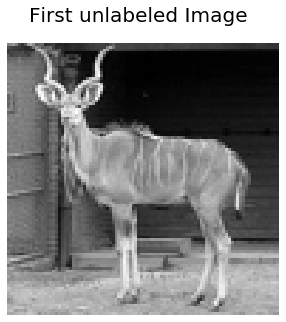

In [5]:
unlabeled_images = read_all_images(x_unlabeled)
unlabeled_images = np.array([rgb2gray(i) for i in unlabeled_images])
title = "First unlabeled Image"
plot_images(unlabeled_images, title=title)
orig_shape = unlabeled_images.shape

# PCA ALGORITHM

### Mean subtraction:
$$\begin{equation*}
\textbf{ x }_{n} = \textbf{x}_{n} - \mu
\end{equation*}$$

### Divide by standard deviation:¶
$$\begin{equation*}
\textbf{ x }_{n} = \textbf{x}_{n} / \sigma
\end{equation*}$$

### Formulate data matrix and covariance matrix:
$$
\textbf{X} = [ \textbf{x}_1, ..., \textbf{x}_n ]
$$$$
\textbf{S} = \frac{1}{N}\textbf{XX}^T
$$

### Perform Eigendecomposition
$$\textbf{S}=\textbf{B}\textbf{D}\textbf{B}^{-1}$$

### Projection or Low-Rank Approximation of $\textbf{X}$: 
$$
\textbf{R} = \textbf{B}_{M}\textbf{B}^{T}_{M}\textbf{X}
$$

### Backprojection:
$$\begin{equation*}
\textbf{ x }_{n} = \textbf{x}_{n}\sigma + \mu
\end{equation*}$$

### Perform PCA
Part 1: Low-dimensionality reduction using PCA

Using STL-10 10k unlabeled dataset, build a PCA with the minimum dimensionality and best reconstruction quality
Plot 𝑀𝑆𝐸 vs 𝒛−𝑑𝑖𝑚

Mean squared error for the entire test set vs 𝒛 code dimensionality

Try the following dims: {32, 64, 256, 512, 1028, 2046, 4098}

In [6]:
# from https://github.com/roatienza/ml/blob/master/pca/notebook/pca.ipynb

def PCA(orig_images, components):
    
    #create a mean-centered X
    images = orig_images
    mu = np.mean(images)
    images -= mu
    
    #divide by standard deviation
    std = np.std(images)
    images /= std
    
    # Perform Eigendecomposition
    X = np.reshape(images,(-1,len(orig_images)))
    S = np.matmul(X, np.transpose(X))/len(orig_images)
    D,B = la.eig(S,left=True,right=False)
    orig_shape = unlabeled_images.shape

    # Projection or Low-Rank Approximation of X:
    BM = B[:,:components]
    BM_BMT = np.matmul(BM,np.transpose(BM))
    R = np.matmul(BM_BMT,X)
    R = np.reshape(R, orig_images.shape)
    
    # Backprojection
    R *= std
    R += mu
    R = np.clip(R, 0, 255)
    
    return R

# define mean squred error function
def MSE(orig, new):
    return np.abs((np.square(orig- new)).mean(axis=None))



### Perform PCA on given dims {32, 64, 256, 512, 1028, 2046, 4098}

In [11]:
# sample first 10000 images from unlabeled dataset
orig_images = unlabeled_images[0:10000]

# create vector for principal components for plotting
principal_components = [32, 64, 256, 512, 1028, 2046, 4098]
# create vector for MSE for plotting
MSE_vec = []

# apply PCA to different dimensions and cget the mean square error
for i in principal_components:
    reconstructed_images = PCA(orig_images,i)
    Mean_Square_Error = MSE(orig_images,reconstructed_images)
    print('Dim =', i, "   Mean Squared Error = ", Mean_Square_Error)
    MSE_vec.append(Mean_Square_Error)

Dim = 32    Mean Squared Error =  0.6536754237338196
Dim = 64    Mean Squared Error =  0.613512385122777
Dim = 256    Mean Squared Error =  0.5502863275834401
Dim = 512    Mean Squared Error =  0.5259592785851511
Dim = 1028    Mean Squared Error =  0.5056269047940254
Dim = 2046    Mean Squared Error =  0.490281922663978
Dim = 4098    Mean Squared Error =  0.481138306545561


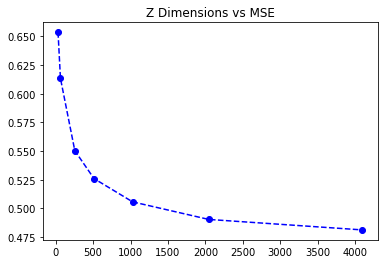

In [117]:
# Plot the MSE
plt.plot(principal_components, MSE_vec, '--bo')
plt.title('Z Dimensions vs MSE')
plt.show()
plt.close('all')

## Verify result with Test Data

In [114]:
# load x_test from directory
x_test_images = read_all_images(x_test)
# convert to grayscale
x_test_images = np.array([rgb2gray(i) for i in x_test_images])

# create vector for test MSE for plotting
MSE_test_vec = []

# apply PCA to different dimensions and get the mean square error
for i in principal_components:
    reconstructed_test_images = PCA(x_test_images,i)
    Mean_Square_Error_test = MSE(x_test_images,reconstructed_test_images)
    print('Dim =', i, "   Mean Squared Error = ", Mean_Square_Error_test)
    MSE_test_vec.append(Mean_Square_Error_test)

Dim = 32    Mean Squared Error =  15231.092217711317
Dim = 64    Mean Squared Error =  0.5998599640080329
Dim = 256    Mean Squared Error =  0.5404116506250245
Dim = 512    Mean Squared Error =  0.5176613900849102
Dim = 1028    Mean Squared Error =  0.4989577015298029
Dim = 2046    Mean Squared Error =  0.4855161350213605
Dim = 4098    Mean Squared Error =  0.4782979071283527


Discard the dimension = 32 since we all know based on the the resulting high MSE and for the reason that it can not reconstruct the original image

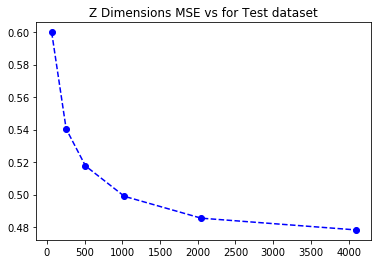

In [119]:
# Plot the MSE for test dataset
# discard the outlier Dim=32
plt.plot(principal_components[1:7], mse_abs[1:7], '--bo')
plt.title('Z Dimensions MSE vs for Test dataset')
plt.show()
plt.close('all')

Comparing the results of unlabled MSE and test data MSE , we cannot choose dim=4098 eventhough it has the lowest MSE.

We can chose our optimal Zdim = 1028 with MSE = 0.49

# Reconstruction of test dataset using 1028 components
## Original Test Data VS Reconstructed Data

In [87]:
# use PCA with dim=1028
reconstructed_images_1028 = PCA(x_test_images,1028)

In [111]:
# convert to float
ximage = reconstructed_images_1028
ximage= np.float32(ximage)

C:\Users\kenshi410\anaconda3\lib\site-packages\ipykernel_launcher.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  


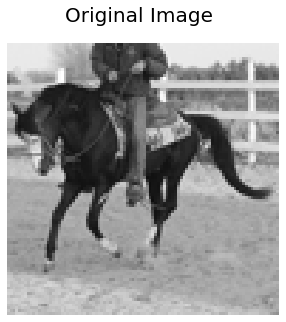

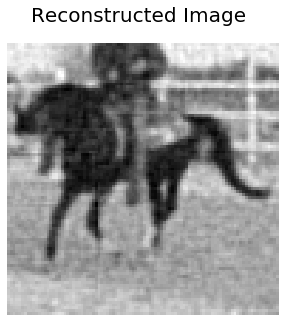

In [112]:
# plot original image and recontructed image
x_test_images = read_all_images(x_test)
x_test_images = np.array([rgb2gray(i) for i in x_test_images])
title = "Original Image"
plot_images(x_test_images, title=title)
#orig_shape = x_test_images.shape

title = "Reconstructed Image"
plot_images(ximage, title=title)

# Gaussian Mixture Model

Can we fit a 10-component GMM on the unlabeled dataset 𝒛 code vectors from PCA?

Can we use the GMM and labeled train set to assign labels to the 10 clusters in GMM?

Report the accuracy on the test dataset.

Can we build an STL generative model using unlabeled dataset PCA 𝒛 code vectors and GMM?

In [9]:
# get 10000 sample images from unlabled dataset
orig_images = unlabeled_images[0:10000]
reconstructed_unlabeled_1028 = PCA(orig_images,1028)

In [34]:
# reshape the unlabeled dataset
unlabeled_1028 = reconstructed_unlabeled_1028
unlabeled_1028 = np.reshape(unlabeled_1028,(-1,len(unlabeled_1028)))

In [36]:
# fit 10-component GMM 
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=10, covariance_type='full')
gm.fit(unlabeled_1028)
outlier_scores = gm.score_samples(unlabeled_1028)

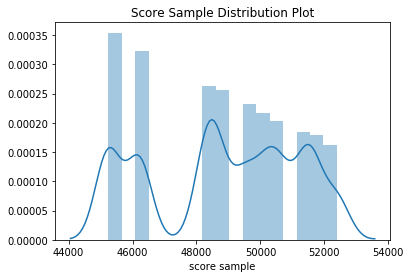

In [40]:
# Check for outlier threshold
import seaborn as sns
import matplotlib.pyplot as plt
sns.distplot(outlier_scores);
plt.xlabel("score sample")
plt.title("Score Sample Distribution Plot")
plt.show()

In [74]:
clusters = gm.predict(unlabeled_1028)

In [ ]:
gg = -1:10

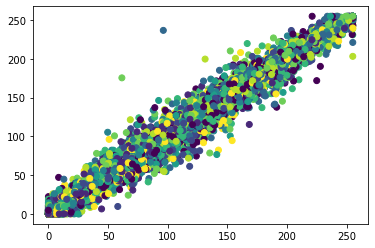

In [73]:
plt.scatter(unlabeled_1028[:, 0], unlabeled_1028[:, 1], c=clusters, cmap='viridis');